In [25]:
import numpy as np 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import re
import random
import math
import pandas as pd 
from sklearn import metrics
import matplotlib.pyplot as plt

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

#Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Import Files

In [27]:
o = os.getcwd()

data = pd.read_csv(o + "\\..\\data\\cases_train_processed.csv", parse_dates = True)
data_test = pd.read_csv(o + "\\..\\data\\cases_test_processed.csv", parse_dates=True)
plot_path = o + "\\..\\plots\\"
results_path = o + "\\..\\results\\"

'''
# For Mac/Linux
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates = True)
data_test = pd.read_csv(o + "/../data/cases_test_processed.csv", parse_dates = True)
plot_path = o + "/../plots/"
results_path = o + "/../results/"
'''

'\n# For Mac/Linux\ndata = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates = True)\ndata_test = pd.read_csv(o + "/../data/cases_test_processed.csv", parse_dates = True)\nplot_path = o + "/../plots/"\nresults_path = o + "/../results/"\n'

## Categorize Functions

In [28]:
# converts string Series into a cataegorized int series for data analysis
def categorize_column(data):
    i = 0
    for value in tqdm(data.unique()):
        data.replace(value, i, inplace = True)
        i += 1
    data = data.apply(pd.to_numeric)
    return data

# converts string Series into a cataegorized int series1 for data analysis
def categorize_outcome(data):
    data = data.map({'nonhospitalized':0, 'deceased':1, 'recovered':2, 'hospitalized':3},na_action ='ignore')
    data = data.apply(pd.to_numeric)
    return data

## Data Cleanup Functions

In [29]:
def cleanup(data):
    data = data.drop(columns=['province', 'country'])
    data['sex'] = categorize_column(data['sex'])
    data['outcome'] = categorize_outcome(data['outcome'])
    data['Combined_Key'] = categorize_column(data['Combined_Key'])
    return data

## Data Output Functions

In [30]:
def output_predictions(p):
    pred = []
    arr = {0:'nonhospitalized', 1:'deceased',2:'recovered', 3:'hospitalized'}
    for i in p:
        pred.append(arr[i])
    with open(results_path+"predictions.txt", "w") as f:
        f.writelines('\n'.join(pred))

In [31]:
data = cleanup(data)
data_test = cleanup(data_test)

100%|██████████| 413/413 [00:04<00:00, 95.75it/s]


## Build and Run AdaBoostClassifier

In [32]:
abc  = AdaBoostClassifier()
params = {'n_estimators': [100,150], 'learning_rate': [1,1.5,2]}
cv = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
scoring = {'Overall_Accuracy': metrics.make_scorer(metrics.accuracy_score),
           'Overall_Recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
           'F1_Deceased': metrics.make_scorer(metrics.f1_score, labels=[1], average= 'micro'),
           'Recall_Deceased': metrics.make_scorer(metrics.recall_score, labels = [1], average = 'micro') }

X = data.drop(columns='outcome')
y = data['outcome']

#n_scores = cross_val_score(abc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
gs = GridSearchCV(abc, param_grid = params, scoring= scoring, cv=cv, n_jobs=-1, refit = 'F1_Deceased')

In [33]:
gs.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=15, random_state=1),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1, 1.5, 2],
                         'n_estimators': [100, 150]},
             refit='F1_Deceased',
             scoring={'F1_Deceased': make_scorer(f1_score, labels=[1], average=micro),
                      'Overall_Accuracy': make_scorer(accuracy_score),
                      'Overall_Recall': make_scorer(recall_score, average=macro),
                      'Recall_Deceased': make_scorer(recall_score, labels=[1], average=micro)})

## Classifier Results

In [34]:
gs.cv_results_

6210759]),
 'split22_test_Overall_Accuracy': array([0.65294603, 0.59606617, 0.66241153, 0.61551821, 0.73027658,
        0.73027658]),
 'split23_test_Overall_Accuracy': array([0.63162694, 0.71703356, 0.66736138, 0.53271677, 0.72945161,
        0.72945161]),
 'split24_test_Overall_Accuracy': array([0.66319309, 0.62863098, 0.67139942, 0.58833746, 0.72992923,
        0.72992923]),
 'split25_test_Overall_Accuracy': array([0.62402848, 0.59867136, 0.69289219, 0.50149798, 0.73045026,
        0.73045026]),
 'split26_test_Overall_Accuracy': array([0.68841996, 0.71373366, 0.69584473, 0.53375885, 0.72945161,
        0.72945161]),
 'split27_test_Overall_Accuracy': array([0.68468586, 0.67261517, 0.58477704, 0.51639095, 0.73023316,
        0.73023316]),
 'split28_test_Overall_Accuracy': array([0.65806956, 0.653771  , 0.67734792, 0.56849464, 0.6905041 ,
        0.6905041 ]),
 'split29_test_Overall_Accuracy': array([0.71594807, 0.6981894 , 0.69567105, 0.61404194, 0.72988581,
        0.72988581]),
 'spl

## Exporting Predictions and Model

In [35]:
def create_model_file(gs, filename):
    lines = str(gs.cv_results_)
    line_list = lines.split(',')
    with open(filename, 'w') as f:
        f.writelines(',\n'.join(line_list))

In [36]:
adb_file = plot_path + "adb_file.txt"
create_model_file(gs, adb_file)

In [37]:
gs.best_estimator_

AdaBoostClassifier(learning_rate=1.5, n_estimators=150)

adb=gs.best_estimator_.fit(X,y)

In [38]:
p = gs.best_estimator_.predict(data_test.drop(columns='outcome'))
output_predictions(p)


In [48]:
def plot_overall_accuracy(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Overall_Accuracy']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Overall_Accuracy']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Overall Accuracy Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')
    plt.savefig(plot_path+'adb_overall_accuracy.png')

In [49]:
def plot_overall_recall(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Overall_Recall']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Overall_Recall']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Overall Recall Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')
    plt.savefig(plot_path+'adb_overall_recall.png')    

In [50]:
def plot_F1_deceased(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_F1_Deceased']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_F1_Deceased']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("F1 Deceased Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')
    plt.savefig(plot_path+'adb_F1_deceased.png')    

In [51]:
def plot_recall_deceased(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_Recall_Deceased']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_Recall_Deceased']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Recall Deceased Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=9, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=9, fontweight='bold')
    ax.legend(loc="best", fontsize=8)
    ax.grid('on')
    plt.savefig(plot_path+'adb_F1_recall.png')    

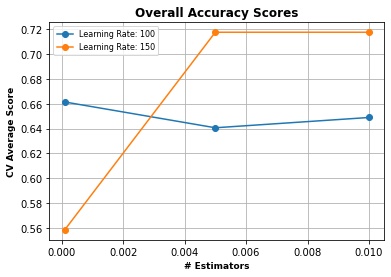

In [52]:
n_est = [0.0001, 0.005, 0.01] 
lr = [100, 150] 
plot_overall_accuracy(gs.cv_results_, n_est, lr, '# Estimators', 'Learning Rate')

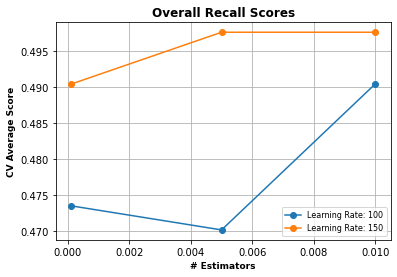

In [53]:
plot_overall_recall(gs.cv_results_, n_est, lr, '# Estimators', 'Learning Rate')

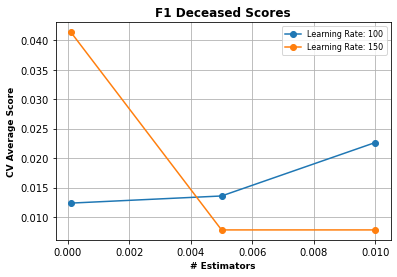

In [54]:
plot_F1_deceased(gs.cv_results_, n_est, lr, '# Estimators', 'Learning Rate')

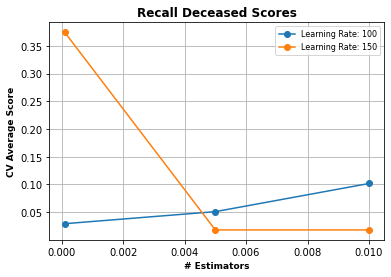

In [55]:
plot_recall_deceased(gs.cv_results_, n_est, lr, '# Estimators', 'Learning Rate')